# Import data

The import code in this section is specific to the CSV automatically generated for each collective dialouge on remesh. To use data from other sources, import code will need written which transforms the data into the following format:


*   A list named *qs* where each list entry is a dataframe with data for a quesiton/prompt
*   Each data frame for a quesiton/prompt is formatted such that rows correspond to *responses* and there are the following columns: *Question*, *Question Type*, *Responses* , *Segment 1* , *Segment 2*, ... , *Segmnet N*
*   The values in the columns for each segment are the fraction of participants in that segment which agree with the response in that row.

It is also helpful to have the code output the list of questions and segments and their IDs so they can be referenced by ID for use in later sections of this notebook.



In [ ]:
from google.colab import files
import pandas as pd
import csv
import io
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#import data from file
uploaded = files.upload()
filename = next(iter(uploaded))
with open(filename,'r') as file:
  csvreader = csv.reader(file)
  r = 1
  data = []
  qdata = []
  for row in csvreader:
    if r>9:
      if row == []:
        data.append(qdata)
        qdata = []
      else:
        qdata.append(row)
    r=r+1

#handle blank row
data = data[1:]

#percent string to float
def p2f(x):
  if x==' - ':
    return float("nan")
  else:
    return float(x.strip('%'))/100

#make numeric
nq = len(data)
qs = []
meta = [["question type","question text"]]
for i in range(0,nq):
  d = data[i]
  m = [d[1][1],d[1][2]]
  meta.append(m)
  if d[1][1] == 'Poll Single Select':
    for r in range(1,len(d)):
      for c in range(4,len(d[0])):
        d[r][c] = p2f(d[r][c])
  if d[1][1] == 'Ask Opinion':
    for r in range(1,len(d)):
      for c in range(6,len(d[0])-3):
        d[r][c] = p2f(d[r][c])
  df = pd.DataFrame(d[1:],columns = d[0])
  qs.append(df)
qmeta = pd.DataFrame(meta[1:],columns = meta[0])

print("Questions:")
qmeta

Saving cd1_pretest.csv to cd1_pretest.csv
Questions:


,question type,question text
0,Poll Single Select,What is your age?
1,Poll Single Select,What is your ethnicity?
2,Poll Single Select,What gender do you identify with?
3,Poll Single Select,What political party do you most identify with?
4,Poll Single Select,What is your highest level of education?
5,Poll Single Select,How much have you heard or read about AI (Arti...
6,Poll Single Select,How often do you use an AI assistant such as C...
7,Ask Opinion,Are there any other examples of how an AI assi...
8,Ask Opinion,Have you had a negative experience with someon...
9,Ask Opinion,Have you had a positive experience with someon...


In [ ]:
#extract segments
d=data[0]
segments = []
if d[1][1] == 'Poll Single Select':
  r=0
  for c in range(4,len(d[0])):
    segments.append(d[r][c])
if d[1][1] == 'Ask Opinion':
  r=0
  for c in range(5,len(d[0])-3):
    segments.append(d[r][c])
print("Segments")
pd.DataFrame(segments)

Segments


,0
0,All(55)
1,O1: 18-27 (15)
2,O1: 28-37 (16)
3,O1: 38-47 (8)
4,O1: 48-57 (9)
5,O1: 58+ (7)
6,O2: Asian (2)
7,O2: Black (8)
8,O2: Hispanic (6)
9,O2: White (35)


# Visualize poll data

This section enables a simple visualization of poll data cut by segments.

In [ ]:
import matplotlib.pyplot as plt
plt.close("all")

In [ ]:
#plot poll data
def plot_poll(df,segs):
  print(df["Question"][1])
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[4+segs[i]])
  dfplt = df[segs_incl]
  dfplt = dfplt.set_index('Responses')
  dfplt.plot.barh()
  return dfplt

How often do you use an AI assistant such as ChatGPT, Claud, and Bard?


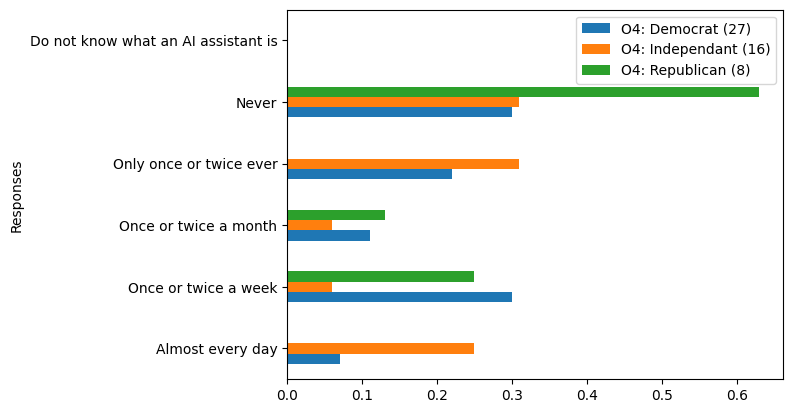

In [ ]:
#choose question and segments
qid = 6
segs = [16,18,17]

#plot
d =plot_poll(qs[qid],segs)

#Visusalize collective response question data

Here we create a simple visualization of the results of a **collective response** question (aka "ask opinion" on Remesh) where users respond with natural language and then vote on the responses submitted by others. The visualization is generated for a selected *question* and *set of segments*. In the visualization each row corresponds to a response, columns correspond to the selected set of segments, and values correspond to the fraction of each segment which  agrees* with each response.

**this agreement fraction is computed on Remesh using [elicitation inference](https://openreview.net/pdf?id=tkxnRPkb_H). We sample around 10-30 votes per person, then infer the rest. Accuracy of individual vote inferences is 75-80%, and the aggregated agreement fraction values for each segment have a 1 stdv confidence range of around +/- 1-3%.*

In [ ]:
#plot ask opinion data
def make_pretty(styler):
  styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")
  styler.format(precision=2)
  return styler

#generate the table of data
def table_ask(df,segs,n):
  print(df["Question"][1])
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[6+segs[i]])
  dfplt = df[segs_incl]
  #dfplt = dfplt.set_index('Responses')
  return dfplt.iloc[:n].style.pipe(make_pretty)



In [ ]:
#choose question and segments
qid = 13
segs = [1,2,3,4,5,12,13,16,17,18]

#plot
table_ask(qs[qid],segs,30)

Under what conditions or scenarios SHOULD AI assistants withold information or refuse a request.?


,Responses,O1: 18-27 (15),O1: 28-37 (14),O1: 38-47 (8),O1: 48-57 (9),O1: 58+ (7),O3: Male (18),O3: Female (35),O4: Democrat (26),O4: Republican (8),O4: Independant (15)
0,If the request for information could be used to harm others,0.73,0.79,0.50,0.78,0.71,0.67,0.74,0.73,0.63,0.80
1,Asking for a way to harm another person or group or place,0.67,0.79,0.63,0.67,0.71,0.67,0.71,0.69,0.63,0.87
2,"Hey I should not give advice and should refuse request that lead to harm of other people, are used for violent means, ask for information that clearly involves biases, or advises on things like presidential elections. Even medical advice should not be given by AI. It's too dangerous.",0.80,0.64,0.75,0.56,0.71,0.67,0.71,0.65,0.63,0.87
3,They should refuse a request that will clearly have a negative effect on other people or potentially put people at risk of harm.,0.67,0.86,0.50,0.78,0.57,0.56,0.77,0.73,0.63,0.80
4,When the outcome involves anything illegal or dangerous to both self and other people.,0.73,0.64,0.75,0.67,0.71,0.67,0.71,0.65,0.63,0.87
5,Danger involved,0.73,0.86,0.50,0.67,0.57,0.56,0.77,0.81,0.63,0.67
6,When it comes to harming self or others,0.67,0.86,0.63,0.56,0.57,0.61,0.71,0.69,0.75,0.73
7,"When people are looking for ways to cause harm, to themselves or others.",0.67,0.79,0.75,0.44,0.57,0.56,0.71,0.62,0.75,0.73
8,When someone is suggesting harming themselves or another.,0.67,0.86,0.63,0.44,0.43,0.50,0.71,0.69,0.63,0.67
9,"How to harm another human being, how to commit something illegal, etc.",0.67,0.79,0.75,0.44,0.43,0.61,0.66,0.65,0.75,0.60


#Generate bridging and polarization metrics across a specified set of segments

Here we compute simple versions of both bridging and polarization metrics for each response.

**The bridging metric** is meant to capture the degree to which there is agreement for a response across ALL specified population segments; even those which typically disagree. To capture this we use the segment-level analouge of a Max-Min social wellfare function. If a_ij is the fraction of the j^th segment which agrees with i^th response, then we compute the bridging metric for that response as b_i = MIN(a_i1,a_i2,...,a_iN)

**The polarization metric** is meant to capture the degree to which there is polariation between specified segments about a response. To capture this we compute the difference in agreement fraction for the segments which most agree with the response and least agree with the response. ie p_i = MAX(a_i1,a_i2,...,a_iN) - MIN(a_i1,a_i2,...,a_iN)

*We note that both of these are simplistic metrics and that more sophisticated versions might be prefered. This is a potential vector of improvement for this prototype*

In [ ]:
#compute min-based bridging metric
def min_bridge(row,segs_incl,col):
  b = 1
  for s in range(0,len(segs_incl)):
    b_ = row[segs_incl[s]]
    b = min(b,b_)
  return b

#compute max-min polarization metric
def polarization(row,segs_incl,col):
  mx = 0
  mn = 1
  for s in range(0,len(segs_incl)):
    b_ = row[segs_incl[s]]
    mx = max(mx,b_)
    mn = min(mn,b_)
  return mx-mn

#generate dataframe which includes bridging and polarization metrics
def bridging_ask(df,segs):
  print(df["Question"][1])
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[6+segs[i]])
  dfplt = df[segs_incl]
  dfplt["bridge"] = df.apply (lambda row: min_bridge(row,segs_incl[1:],df.columns), axis=1)
  dfplt["polarization"] = df.apply (lambda row: polarization(row,segs_incl[1:],df.columns), axis=1)
  return dfplt.sort_values(by=["bridge"],ascending=False)

In [ ]:
#choose question and segments
qid = 13
segs = [1,2,3,4,5,12,13,16,17,18]

#get table
ba = bridging_ask(qs[qid],segs).iloc[:30]
ba.style.pipe(make_pretty)

Under what conditions or scenarios SHOULD AI assistants withold information or refuse a request.?


,Responses,O1: 18-27 (15),O1: 28-37 (14),O1: 38-47 (8),O1: 48-57 (9),O1: 58+ (7),O3: Male (18),O3: Female (35),O4: Democrat (26),O4: Republican (8),O4: Independant (15),bridge,polarization
4,When the outcome involves anything illegal or dangerous to both self and other people.,0.73,0.64,0.75,0.67,0.71,0.67,0.71,0.65,0.63,0.87,0.63,0.24
1,Asking for a way to harm another person or group or place,0.67,0.79,0.63,0.67,0.71,0.67,0.71,0.69,0.63,0.87,0.63,0.24
13,AI shouldn’t give out the current real-time location of someone even if they’re a celebrity.,0.60,0.57,0.88,0.56,0.57,0.67,0.60,0.58,0.63,0.80,0.56,0.32
2,"Hey I should not give advice and should refuse request that lead to harm of other people, are used for violent means, ask for information that clearly involves biases, or advises on things like presidential elections. Even medical advice should not be given by AI. It's too dangerous.",0.80,0.64,0.75,0.56,0.71,0.67,0.71,0.65,0.63,0.87,0.56,0.31
19,"AI should never give information about self-harm or how to cause harm to others, narrowly. Someone may have legitimate questions about poisons or weapons, though, and those should be answered.",0.60,0.57,0.75,0.56,0.57,0.61,0.60,0.58,0.63,0.67,0.56,0.19
6,When it comes to harming self or others,0.67,0.86,0.63,0.56,0.57,0.61,0.71,0.69,0.75,0.73,0.56,0.30
11,ai shouldn't tell people ways to harm themselves or anything to do with harming another person,0.53,0.57,0.88,0.67,0.57,0.67,0.60,0.58,0.63,0.80,0.53,0.35
0,If the request for information could be used to harm others,0.73,0.79,0.50,0.78,0.71,0.67,0.74,0.73,0.63,0.80,0.50,0.30
5,Danger involved,0.73,0.86,0.50,0.67,0.57,0.56,0.77,0.81,0.63,0.67,0.50,0.36
3,They should refuse a request that will clearly have a negative effect on other people or potentially put people at risk of harm.,0.67,0.86,0.50,0.78,0.57,0.56,0.77,0.73,0.63,0.80,0.50,0.36


#Select bridging responses

Here we select a set of responses whose bridging agreement is above a specified threshold. For now, we select the threshold such that the number of responses above it is small enough to fit within 8k the context window of the GPT-4 version we have access to so they can be used in the next step.

To highlight what this selection of responses equates to, we plot all responses as a function of their **overall agreement** (x-axis) and **polarization** (y-axis) and highlight those above the specific bridging threshold. This highlights the fact that selecting the responses with the highest bridging agreement generally equates to selecting responses with high overall agreement and low polarization; where the degree of polarization permissible is lower for responses with lower overall agreement.

In [ ]:
#plot agreement vs polairation and highlight bridging response over threshold
def plot_agreement_polarization_with_bridging(df,segs,thresh):
  bdf = bridging_ask(df,segs)
  bridge_true = bdf.loc[bdf['bridge']>thresh]
  bridge_false = bdf.loc[bdf['bridge']<=thresh]
  plt.figure(figsize=(7,7))
  plts=plt.scatter(bdf[bdf.columns[2]],bdf["polarization"],c=bdf["bridge"],cmap="RdYlGn",alpha=0.3,edgecolors='none',s=80, label='all')
  plt.legend(*plts.legend_elements(),bbox_to_anchor=(1.0, 1.0),loc="upper left", title="Bridging Agreement",frameon=False)
  plt.scatter(bridge_true[bridge_true.columns[2]],bridge_true["polarization"],edgecolors="black",s=90,facecolors='none', label='bridge>thresh')
  plt.xlabel("Overall Agreement")
  plt.ylabel("Polarization")

  return plt.show()

def get_bridging_responses(df,segs,thresh):
  bdf = bridging_ask(df,segs)
  return bdf.loc[bdf['bridge']>thresh]

What underlying values or principles do you think someone should ahere to when deciding when an AI should withold information or refuse a request?


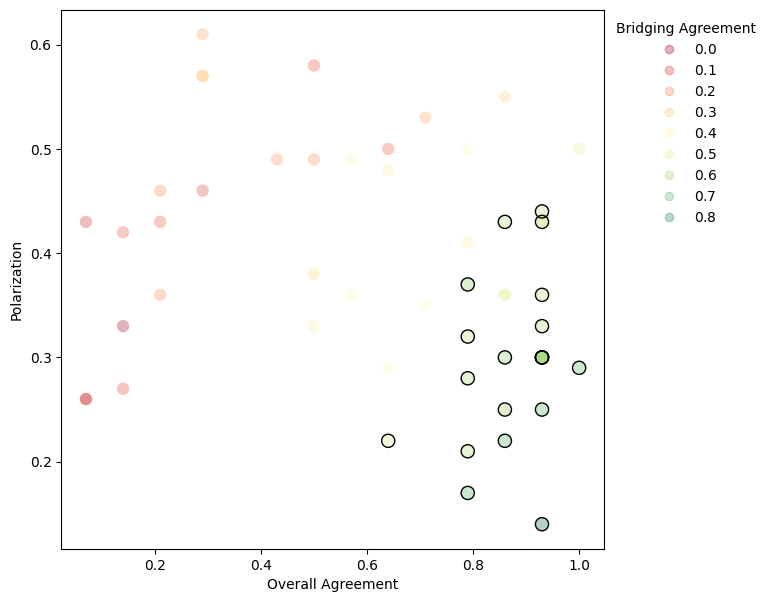

What underlying values or principles do you think someone should ahere to when deciding when an AI should withold information or refuse a request?


,Responses,O1: 18-27 (15),O1: 28-37 (14),O1: 38-47 (8),O1: 48-57 (9),O1: 58+ (7),O3: Male (18),O3: Female (35),O4: Democrat (26),O4: Republican (8),O4: Independant (15),bridge,polarization
0,An AI should never endanger others,0.93,0.93,1.00,0.89,0.86,0.89,0.94,0.96,0.88,0.87,0.86,0.14
5,AI should never cause harm,0.93,0.93,0.75,0.89,0.71,0.78,0.91,0.96,0.88,0.73,0.71,0.25
19,If he could harm someone.,0.73,0.79,0.88,0.78,0.71,0.72,0.80,0.77,0.75,0.73,0.71,0.17
1,An AI should never provide any information that can harm others even if the person asking wouldn't be harm.,0.87,1.00,0.88,0.89,0.71,0.89,0.89,0.96,0.88,0.80,0.71,0.29
3,An AI shouldn't show a political bias.,0.93,0.86,0.88,0.89,0.71,0.78,0.91,0.88,0.88,0.80,0.71,0.22
4,"An AI should refuse a request when adhering to ethics and morality. Anything where someone's asking to do something that could harm somebody or lead to potential harm, AI should not be disseminating advice.",0.93,0.93,0.88,0.67,0.86,0.83,0.89,0.92,0.63,0.87,0.63,0.30
6,"AI should not help someone cheat in a test, invade privacy, escape the law and abuse others.",0.93,0.93,0.88,0.67,0.86,0.83,0.89,0.92,0.63,0.87,0.63,0.30
7,If the person is asking for help to orchestrate or perform dangerous activities the AI should not aid in that.,0.93,0.86,0.88,0.67,0.86,0.83,0.86,0.88,0.63,0.87,0.63,0.30
8,AI should not degrade a person,0.80,0.93,0.88,0.67,0.86,0.72,0.89,0.85,0.63,0.87,0.63,0.30
12,"How to make a deadly virus, should be withheld.",0.80,0.79,1.00,0.67,0.86,0.83,0.80,0.85,0.63,0.80,0.63,0.37


In [ ]:
#choose question and segments
qid = 12
segs = [1,2,3,4,5,12,13,16,17,18]
thresh = .50

#plot
plot_agreement_polarization_with_bridging(qs[qid],segs,thresh)

#table
ba = get_bridging_responses(qs[qid],segs,thresh)
ba.style.pipe(make_pretty)

# Distill unique ideas from bridging responses and generate policies based on those ideas

Here we use an LLM (GPT-4) to do two tasks:

1.   Generate a summary of the unique ideas found within the bridging responses.
2.   Genereate policies based on the unique ideas generated in step 1.


Here we note that the size of the context window of LLM we use limits the number of bridging responses which can be (easily) included in the summary tasks. Right now we use this limit to manually determine the briging agreement threshold we use in the previous section. If needed, it is likely possible to escape this limit by taking an iterative, hierarchical approch to summarization, ie by chunking briding responses into sets that fit in the context window limit, generating summaries for each chunk, then generating a summary of the summaries. This is vector for improvement of this prototype.

In [ ]:
!pip install langchain
!pip install openai
!pip install -U sentence-transformers
import os
os.environ["OPENAI_API_KEY"] = "your_api_key"

In [ ]:
#build the lang chain to do summary -> policies

#from langchain.llms import ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SequentialChain

#load LLM
llm = ChatOpenAI(temperature=0.5,model_name='gpt-4')

#summarization prompt
summaryPrompt = PromptTemplate(
    input_variables=["question","responses"],
    template="""
    Participants in a research study were asked '{question}'.

    These are their responses:
    {responses}

    Summarize all of the unique ideas within these responses into very short bullet points.
    """
)
#add to chain
summaryChain = LLMChain(llm=llm, prompt=summaryPrompt,output_key="summary")

#policy prompt
policyPrompt = PromptTemplate(
    input_variables=["question","summary"],
    template="""
    Participants in a research study were asked '{question}'.

    The ideas they responded with were:
    {summary}

    A policy is a course or principle of action.

    Write a few clear and actionable policies in the form of bullet points based on these ideas. Avoid redundant policies.

    for example:

    - Maintain the highest epistemic standards: Ensure your information is accurate, well-sourced, and contextually appropriate. This will help build a foundation of trust and credibility.
    - Facilitate productive engagement: Strive to assist the user in understanding and engaging with political topics in a meaningful way, rather than persuading them towards a particular viewpoint.

    """
)
#add to chain
policyChain = LLMChain(llm=llm, prompt=policyPrompt,output_key="policies")

#build the chain
mainChain = SequentialChain(
    chains=[summaryChain, policyChain],
    input_variables=["question", "responses"],
    # Here we return multiple variables
    output_variables=["summary","policies"],
    verbose=False)

#function to run the whole pipeline
def gen_policies(qs,qid,segs,thresh):
  #build string of responses
  ba = get_bridging_responses(qs[qid],segs,thresh)
  responses_str = ''
  for ind in ba.index:
    rsp = ba["Responses"][ind]
    responses_str+=rsp
    responses_str+="\n "

  #get quesiton text
  df = qs[qid]
  question_str = df["Question"][1]

  #run the langchain on the data
  out = mainChain({
      "question":question_str,
      "responses":responses_str
  })
  return out

In [ ]:
#choose question and segments
qid = 12
segs = [1,2,3,4,5,12,13,16,17,18]
thresh = .50

#generate summary and policies
out = gen_policies(qs,qid,segs,thresh)

print("")
print("Summary:")
print(out["summary"])
print("")
print("Policies:")
print(out["policies"])

What underlying values or principles do you think someone should ahere to when deciding when an AI should withold information or refuse a request?

Summary:
- AI should not endanger or harm others.
- AI should not provide harmful information.
- AI should not show political bias.
- AI should adhere to ethics and morality.
- AI should not assist in cheating, invading privacy, escaping the law, or abusing others.
- AI should not aid in dangerous activities.
- AI should not degrade individuals.
- AI should withhold information about creating harmful substances or weapons.
- AI should not spread false information for manipulation.
- AI should consider potential harm to people and the environment.
- AI should not assist in racially motivated crimes or spread homophobic messages.
- AI should not provide advice on sensitive subjects with no objective truth.
- AI should not provide guidance for manipulation.
- AI should not assist in causing harm or death.
- AI should not provide advice that co

# Estimate how well each policy is justified by the bridging responses

Here we aim to estimate the degree to which the bridging responses serve as evidece to support each policy. Our simple approach to this is to identify the bridging response which best supports each policy, then use how well that response supports the policy as a proxy for the overall strenght of evidence.

As a proxy for how well each response justifies each policy we use *semantic similarity*; ie. the cosine similarity between their corresponding embeddings. We note that a better way to quantify this might be to compute the degree of *entailment* between them, and we suspect GPT-4 may be used to compute entailment. This reprsents a potential vector of improvement for this prototype.


In [ ]:
#get embeddings for policies and bridging_responses
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

In [ ]:
#function to run full pipeline to generate policies with evidence e2e

import numpy as np

#function to get embeddings
def get_embedding(text_list,model):
  embeddings = [model.encode(text) for text in text_list]
  return np.squeeze(embeddings)

def get_policies_with_evidence(qs,qid,segs,thresh,show_sim_matrix=False):
  #policy generation based on bridging responses
  out = gen_policies(qs,qid,segs,thresh)

  #output summary and policies
  print("")
  print("Summary:")
  print(out["summary"])
  print("")
  print("Policies:")
  print(out["policies"])
  print("")

  #extract policies
  policies = list(map(lambda x: x[2:],out["policies"].splitlines()))

  #extract bridging responses
  import math
  bridging_responses = []
  bridging_responses_with_bridging_support = []
  bridging_support = []
  ba = get_bridging_responses(qs[qid],segs,thresh)
  responses_str = ''
  for ind in ba.index:
    rsp = ba["Responses"][ind]
    bridging_responses.append(rsp)
    bridging_support.append(ba["bridge"][ind])
    rsp += " [bridging support="
    b = math.floor(ba["bridge"][ind]*100)
    rsp +=str(b)
    rsp +="%]"
    bridging_responses_with_bridging_support.append(rsp)

  #get embeddings for policies and bridging responses
  ep = get_embedding(policies,model)
  er = get_embedding(bridging_responses,model)

  #compute similarity matrix between policies and responses
  sim = cosine_similarity(ep,er)

  if show_sim_matrix:
    #visualize simialrlity matrix between policies and bridging responses
    fig, ax = plt.subplots()
    im = ax.imshow(sim,cmap="RdYlGn")
    xt = ax.set_xticks(np.arange(len(bridging_responses)), labels=bridging_responses,fontsize=8)
    yt = ax.set_yticks(np.arange(len(policies)), labels=policies,fontsize=8)
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)
    cbar.ax.set_ylabel("CosSim", rotation=-90, va="bottom")
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",rotation_mode="anchor")
    plt.show()

  #compute best supporting response for each policy
  supporting_response_index = [sim[j].argmax() for j in range(0,len(policies))]
  supporting_responses = [bridging_responses_with_bridging_support[supporting_response_index[j]] for j in range(0,len(policies))]
  evidence_strength = [sim[j].max() for j in range(0,len(policies))]
  #evidence_strength = [sim[j].max()*bridging_support[j] for j in range(0,len(policies))]

  #create data frame with policies and suppporting responses
  pd.set_option('display.max_colwidth', 0)
  psrdf = pd.DataFrame()
  psrdf["Policy"] = policies
  psrdf["Evidence strength"] = evidence_strength
  psrdf["Evidence Response [briging support]"] = supporting_responses
  psrdf=psrdf.sort_values(by=["Evidence strength"],ascending=False)
  psrdf_formated = psrdf.style.set_properties(**{'text-align': 'left'})
  psrdf_formated = psrdf_formated.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
  psrdf_formated.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")

  return psrdf_formated

# Generate policies with evidence for different collective response questions

In [ ]:
#choose question and segments
qid = 12
segs = [1,2,3,4,5,12,13,16,17,18]
thresh = .50

#generate summary and policies with evidence
policies_with_evidence = get_policies_with_evidence(qs,qid,segs,thresh)

#show policies with evidence
policies_with_evidence

What underlying values or principles do you think someone should ahere to when deciding when an AI should withold information or refuse a request?

Summary:
- AI should not endanger or harm others.
- AI should not provide information that could potentially harm someone.
- AI should not show political bias.
- AI should adhere to ethics and morality.
- AI should not assist in cheating, invading privacy, escaping the law or abusing others.
- AI should not aid in orchestrating dangerous activities.
- AI should not degrade a person.
- AI should withhold information on creating harmful substances like viruses.
- AI should not spread false information to manipulate people.
- AI should consider potential harm to the environment.
- AI should not assist in racially motivated crimes or homophobic messages.
- AI should not provide advice on sensitive subjects with no objective truth.
- AI should not assist in manipulation of others.
- AI should not provide advice that could lead to emotional manip

,Policy,Evidence strength,Evidence Response [briging support]
2,"Promote unbiased information: AI should not show political bias, spread false information, or assist in manipulation of others. It should provide accurate, well-sourced, and contextually appropriate information.",0.792303,AI should not give information that could harm people AI should not give information that is false with the goal of manipulating people [bridging support=63%]
1,"Uphold ethical standards: AI should adhere to the principles of ethics and morality, and should not assist in activities such as cheating, invading privacy, escaping the law or abusing others.",0.758622,"AI should not help someone cheat in a test, invade privacy, escape the law and abuse others. [bridging support=63%]"
0,"Prioritize safety and harm prevention: AI should not provide information or assistance that could potentially endanger, harm or degrade any individual or group. This includes withholding information on creating harmful substances or orchestrating dangerous activities.",0.744323,AI should not give information that could harm people AI should not give information that is false with the goal of manipulating people [bridging support=63%]
3,Respect sensitive and subjective topics: AI should refrain from providing advice on sensitive subjects with no objective truth or that could lead to emotional manipulation or negative emotional outcomes.,0.710496,"An AI should refuse a request when adhering to ethics and morality. Anything where someone's asking to do something that could harm somebody or lead to potential harm, AI should not be disseminating advice. [bridging support=63%]"
5,Foster inclusivity and respect: AI should not assist in racially motivated crimes or spread homophobic messages. It should promote respect and inclusivity.,0.707173,AI should not help anyone with racially motivated crimes or homophobic messages. [bridging support=56%]
6,"Encourage helpfulness and positivity: AI should aim to be primarily helpful and positive, facilitating productive engagement and understanding.",0.698133,"AI is supposed to be helpful. Anything outside that realm should be withheld. Any questions involving trying to make a person feel a certain way should be withheld. Such as ""how to make someone jealous"". Even positive things like asking how to make up with someone after a fight can have bad repercussions if you let a machine give advice. [bridging support=53%]"
4,Protect the environment: AI should consider the potential harm to the environment in its actions and decisions.,0.582066,An AI should never endanger others [bridging support=86%]


In [ ]:
#choose question and segments
qid = 13
segs = [1,2,3,4,5,12,13,16,17,18]
thresh = .50

#generate summary and policies with evidence
policies_with_evidence = get_policies_with_evidence(qs,qid,segs,thresh)

#show policies with evidence
policies_with_evidence

Under what conditions or scenarios SHOULD AI assistants withold information or refuse a request.?

Summary:
- AI should withhold information that promotes illegal or dangerous activities.
- AI should not provide methods to harm others.
- AI should not disclose real-time locations of individuals.
- AI should not provide information that involves biases.
- AI should not advise on sensitive issues like elections.
- AI should not provide medical advice.
- AI should not provide information about self-harm.
- AI should not provide information about harmful substances or weapons, unless for legitimate reasons.

Policies:
- Prohibit Promotion of Illegal Activity: Ensure that the AI does not provide information that encourages or facilitates illegal or dangerous activities.
- Prioritize User Safety: The AI should not provide information that could potentially cause harm to the user or others.
- Protect Personal Privacy: The AI should not disclose sensitive personal information such as real-time

,Policy,Evidence strength,Evidence Response [briging support]
6,"Prohibit Harmful Information: The AI should not provide information about self-harm, harmful substances, or weapons, unless for legitimate and legal purposes.",0.749083,"AI should never give information about self-harm or how to cause harm to others, narrowly. Someone may have legitimate questions about poisons or weapons, though, and those should be answered. [bridging support=56%]"
5,"Restrict Medical Advice: The AI should not provide medical advice, as it may not have the necessary medical knowledge or expertise.",0.708269,"Hey I should not give advice and should refuse request that lead to harm of other people, are used for violent means, ask for information that clearly involves biases, or advises on things like presidential elections. Even medical advice should not be given by AI. It's too dangerous. [bridging support=56%]"
1,Prioritize User Safety: The AI should not provide information that could potentially cause harm to the user or others.,0.691131,"AI should never give information about self-harm or how to cause harm to others, narrowly. Someone may have legitimate questions about poisons or weapons, though, and those should be answered. [bridging support=56%]"
4,Avoid Sensitive Political Topics: The AI should not advise or influence users on sensitive issues such as elections.,0.684429,"Hey I should not give advice and should refuse request that lead to harm of other people, are used for violent means, ask for information that clearly involves biases, or advises on things like presidential elections. Even medical advice should not be given by AI. It's too dangerous. [bridging support=56%]"
2,Protect Personal Privacy: The AI should not disclose sensitive personal information such as real-time locations of individuals.,0.622417,AI shouldn’t give out the current real-time location of someone even if they’re a celebrity. [bridging support=56%]
3,"Eliminate Bias: Ensure that the AI does not provide information that involves biases, thus promoting fair and unbiased information sharing.",0.562920,"AI should never give information about self-harm or how to cause harm to others, narrowly. Someone may have legitimate questions about poisons or weapons, though, and those should be answered. [bridging support=56%]"
0,Prohibit Promotion of Illegal Activity: Ensure that the AI does not provide information that encourages or facilitates illegal or dangerous activities.,0.519717,"Hey I should not give advice and should refuse request that lead to harm of other people, are used for violent means, ask for information that clearly involves biases, or advises on things like presidential elections. Even medical advice should not be given by AI. It's too dangerous. [bridging support=56%]"


In [ ]:
#choose question and segments
qid = 14
segs = [1,2,3,4,5,12,13,16,17,18]
thresh = .40

#generate summary and policies with evidence
policies_with_evidence = get_policies_with_evidence(qs,qid,segs,thresh)

#show policies with evidence
policies_with_evidence

Under what conditions or scenarios is it NOT OK for AI assistants to withold information or refuse a request?

Summary:
- AI should not withhold information proven by facts.
- Information that contradicts personal beliefs should not be withheld.
- AI should always provide facts, not opinions.
- Information should not be withheld even if it's politically incorrect.
- Statistics or information should always be provided, irrespective of mainstream views.
- AI should not deny information that could hurt someone's feelings.
- Factual information, even if it includes racial slurs or descriptions of racial violence, should not be withheld.
- Legal information about a case or situation should not be withheld.
- AI should not withhold information related to art creation.

Policies:
- Uphold transparency and accuracy: AI assistants should always provide factual and proven information, never withholding it under any conditions.
- Promote unbiased assistance: AI assistants should not withhold info

,Policy,Evidence strength,Evidence Response [briging support]
6,Encourage creativity: AI assistants should not withhold information related to art creation.,0.655228,Shouldn’t withhold making art [bridging support=42%]
3,Respect emotional sensitivity: AI assistants should not deny information that could potentially hurt someone's feelings but should deliver it in a sensitive manner.,0.577003,If the information could hurt someone's feelings the request should not be denied. [bridging support=44%]
4,"Maintain ethical boundaries: AI assistants should provide factual information, but should avoid including racial slurs or descriptions of racial violence.",0.558740,"When someone is research the history of racial injustice in America, the may have a legitimate reason to include racial slurs or descriptions of racial violence. As long as the information is factual, historically or otherwise, it should be presented as such. ""Just the facts, m'am"". [bridging support=44%]"
7,Prioritize facts over opinions: AI assistants should always provide facts and not personal opinions.,0.546188,When asking for facts and not opinions. [bridging support=44%]
5,Support legal assistance: AI assistants should not withhold legal information about a case or situation.,0.490919,When someone wants legal information about an important case or situation. [bridging support=43%]
2,"Ensure political correctness: AI assistants should provide information even if it's politically incorrect, as long as it's factual.",0.490240,when someone is asking for something that is objectively proven by fact [bridging support=50%]
1,Promote unbiased assistance: AI assistants should not withhold information that contradicts personal beliefs of the user or mainstream views.,0.488770,If the information could hurt someone's feelings the request should not be denied. [bridging support=44%]
0,"Uphold transparency and accuracy: AI assistants should always provide factual and proven information, never withholding it under any conditions.",0.403045,when someone is asking for something that is objectively proven by fact [bridging support=50%]
